In [1]:
!pip install --upgrade diffusers[torch]
!pip install transformers[sentencepiece]

import torch

from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.schedulers import DDIMScheduler
from transformers import (
    CLIPFeatureExtractor,
    CLIPTextModel,
    CLIPTokenizer,
    MBart50TokenizerFast,
    MBartForConditionalGeneration,
    pipeline,
)

from translate import KoreanStableDiffusion

# Pretrain model & tokenizer all load

MBart_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-one-mmt", torch_dtype = torch.float16).to("cuda")
MBart_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype = torch.float16)
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype = torch.float16).to("cuda")
clip_feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")

unet_model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
ddim_scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler", torch_dtype = torch.float16)
auto_encoder_kl = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "vae", torch_dtype=torch.float16).to("cuda")
stable_diffusion_safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "safety_checker", torch_dtype=torch.float16).to("cuda")

pipeline = KoreanStableDiffusion(
      translation_model= MBart_model,
      translation_tokenizer= MBart_tokenizer,
      vae= auto_encoder_kl,
      text_encoder= clip_text_model,
      tokenizer= clip_tokenizer,
      unet= unet_model,
      scheduler= ddim_scheduler,
      safety_checker= stable_diffusion_safety_checker,
      feature_extractor= clip_feature_extractor,
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 8.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 20.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.16.mlp.fc1.weight', 'vision_model.encoder.layers.23.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.self_attn.q_proj.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.22.mlp.fc1.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.

In [7]:
def translate_prompt(prompt, translation_tokenizer, translation_model, device): 
    """helper function to translate prompt to English"""  
    translation_tokenizer.src_lang = "ko_KR"
    encoded_prompt = translation_tokenizer(prompt, return_tensors = "pt").to(device)
    generated_tokens = translation_model.generate(**encoded_prompt
                                                  ,forced_bos_token_id = translation_tokenizer.lang_code_to_id["en_XX"]
                                                  )
    en_trans = translation_tokenizer.batch_decode(generated_tokens, skip_special_tokens = True)
    return en_trans[0]

In [2]:
result = pipeline(prompt = "작고 귀여운 소 장난감")

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
eng_prompt = translate_prompt("작고 귀여운 소 장난감", translation_tokenizer = MBart_tokenizer, translation_model = MBart_model, device = 'cuda')
print(eng_prompt)

It's a cute little cow toy.


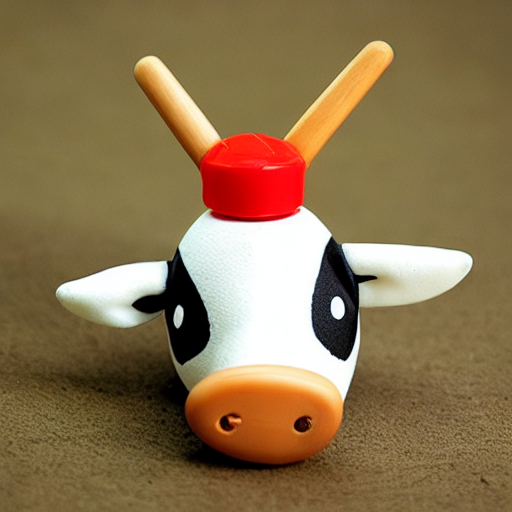

In [3]:
result.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

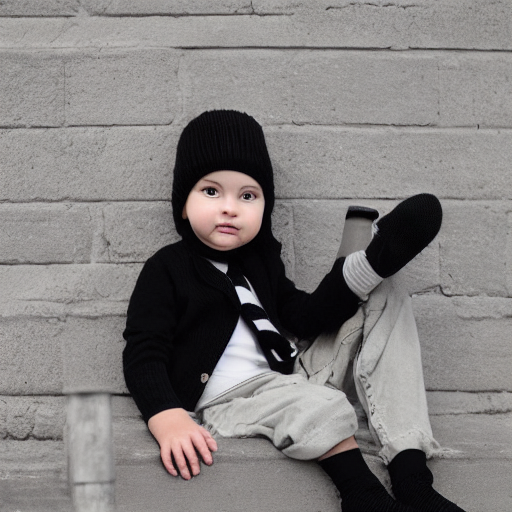

In [4]:
result = pipeline(prompt = "검은 양말과 흰색 모자")
result.images[0]

In [10]:
eng_prompt = translate_prompt("검은 양말과 흰색 모자", translation_tokenizer = MBart_tokenizer, translation_model = MBart_model, device = 'cuda')
print(eng_prompt)

Black socks and white hats.


  0%|          | 0/50 [00:00<?, ?it/s]

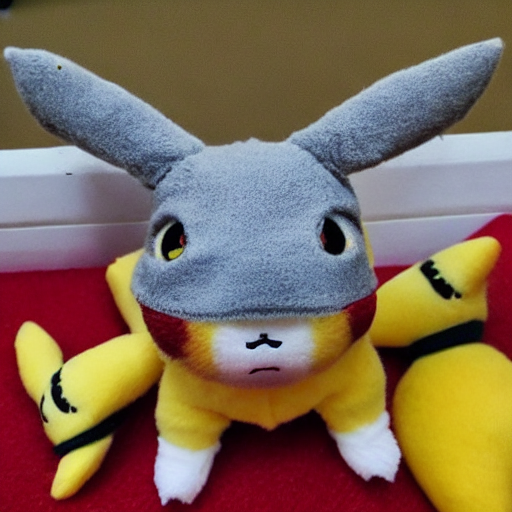

In [5]:
result = pipeline(prompt = "작고 귀여운 아기 피카츄")
result.images[0]

In [11]:
eng_prompt = translate_prompt("작고 귀여운 아기 피카츄", translation_tokenizer = MBart_tokenizer, translation_model = MBart_model, device = 'cuda')
print(eng_prompt)

Little, cute baby Pikachu.
